In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
import scipy.stats as spstat
import time
from conquer.linear_model import high_dim

def cov_generate(std, corr=0.5):
    p = len(std)
    R = np.zeros(shape=[p,p])
    for j in range(p-1):
        R[j, j+1:] = np.array(range(1, len(R[j,j+1:])+1))
    R += R.T
    return np.outer(std, std)*(corr*np.ones(shape=[p,p]))**R

The reference machine used for the simulations below is an iMac with a 3.7 GHz 6-Core Intel i5 processor and 32 GB of RAM. Each simulation exploits only one processor, without any parallelism.

### Bootstrap model selection and post-selection inference for high-dimensional quantile regression

In [2]:
n = 256
p = 1028
s = 8
tau = 0.8
 
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
beta = np.zeros(p)
beta[:21] = [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, -1, 0, 0, -1, 0, 0, -1]
true_set = np.where(beta!=0)[0]
print('true model:', true_set+1)

def boot_sim(m, itcp=True, parallel=False, ncore=0):
    rgt.seed(m)
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = 4 + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    hd_sqr = high_dim(X, Y, intercept=itcp)
    lambda_sim = 0.75*np.quantile(hd_sqr.self_tuning(tau), 0.9)

    boot_model = hd_sqr.boot_inference(Lambda=lambda_sim, tau=tau, weight="Multinomial",
                                       parallel=parallel, ncore=ncore)
    
    per_ci = boot_model['percentile_ci']
    piv_ci = boot_model['pivotal_ci']
    norm_ci = boot_model['normal_ci']
    
    est_set = np.where(boot_model['boot_beta'][itcp:,0]!=0)[0]
    mb_set = boot_model['majority_vote']
    tp =  len(np.intersect1d(true_set, est_set))
    fp  = len(np.setdiff1d(est_set, true_set))
    mb_tp = len(np.intersect1d(true_set, mb_set))
    mb_fp = len(np.setdiff1d(mb_set, true_set))
    
    ci_cover = np.c_[(beta>=per_ci[1:,0])*(beta<=per_ci[1:,1]), 
                     (beta>=piv_ci[1:,0])*(beta<=piv_ci[1:,1]),
                     (beta>=norm_ci[1:,0])*(beta<=norm_ci[1:,1])]
    ci_width = np.c_[per_ci[1:,1] - per_ci[1:,0],
                     piv_ci[1:,1] - piv_ci[1:,0],
                     norm_ci[1:,1] - norm_ci[1:,0]]            
    return {'tp': tp, 'fp': fp, 'mb_tp': mb_tp, 'mb_fp': mb_fp, 
            'ci_cover': ci_cover, 'ci_width': ci_width}

true model: [ 1  3  6  9 12 15 18 21]


In [3]:
ci_cover, ci_width = np.zeros([p, 3]), np.zeros([p, 3])
M = 200
# true and false positives
tp, fp = np.zeros(M), np.zeros(M)
mb_tp, mb_fp = np.zeros(M), np.zeros(M)

runtime = 0
for m in range(M):
    tic = time.time()  
    out = boot_sim(m)
    runtime += time.time() - tic
    
    tp[m], fp[m], mb_tp[m], mb_fp[m] = out['tp'], out['fp'], out['mb_tp'], out['mb_fp']
    ci_cover += out['ci_cover']
    ci_width += out['ci_width']
      
    if (m+1)%10 == 0: print(m+1,'repetitions')

10 repetitions
20 repetitions
30 repetitions
40 repetitions
50 repetitions
60 repetitions
70 repetitions
80 repetitions
90 repetitions
100 repetitions
110 repetitions
120 repetitions
130 repetitions
140 repetitions
150 repetitions
160 repetitions
170 repetitions
180 repetitions
190 repetitions
200 repetitions


In [4]:
cover = pd.DataFrame(ci_cover/M, columns=['percentile', 'pivotal', 'normal'])
width = pd.DataFrame(ci_width/M, columns=['percentile', 'pivotal', 'normal'])

boot_out = pd.concat([width.iloc[true_set,:], cover.iloc[true_set,:]], axis=1)
boot_out.index = boot_out.index + 1
print(boot_out,
      '\ntrue model:',      true_set+1,
      '\naverage runtime:', runtime/M,
      '\ntrue positive:',   np.mean(tp), 
      '\nfalse positive:',  np.mean(fp),
      '\nVSC prob:',        np.mean((tp==8)*(fp==0)), 
      '\ntrue pos after boot:',  np.mean(mb_tp),
      '\nfalse pos after boot:', np.mean(mb_fp),
      '\nVSC prob after boot:',  np.mean((mb_tp==8)*(mb_fp==0)))
# VSC: variable selection consistency

    percentile   pivotal    normal  percentile  pivotal  normal
1     0.324214  0.324214  0.332175       0.975    0.925   0.965
3     0.446478  0.446478  0.453090       0.955    0.920   0.965
6     0.478239  0.478239  0.488555       0.935    0.915   0.950
9     0.418632  0.418632  0.426735       0.950    0.920   0.950
12    0.480288  0.480288  0.488233       0.955    0.915   0.950
15    0.331945  0.331945  0.337306       0.975    0.930   0.970
18    0.396068  0.396068  0.402322       0.955    0.895   0.950
21    0.297853  0.297853  0.304329       0.970    0.930   0.960 
true model: [ 1  3  6  9 12 15 18 21] 
average runtime: 10.51414353132248 
true positive: 8.0 
false positive: 1.375 
VSC prob: 0.29 
true pos after boot: 8.0 
false pos after boot: 0.05 
VSC prob after boot: 0.955


Text(0.5, 1.0, 'Histogram of False Positives')

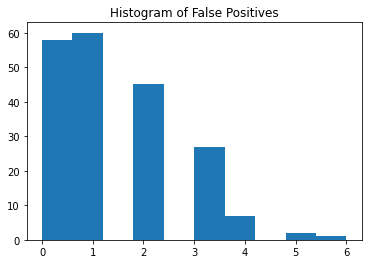

In [5]:
fig1 = plt.hist(fp)
plt.title(r'Histogram of False Positives')

Text(0.5, 1.0, 'Histogram of False Positives after Bootstrap')

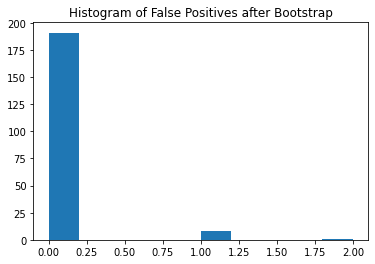

In [6]:
fig2 = plt.hist(mb_fp)
plt.title(r'Histogram of False Positives after Bootstrap')

Under the same model, we implement bootstrap using parallel computing as follows.

In [7]:
from joblib import Parallel, delayed
import multiprocessing
multiprocessing.cpu_count()

6

In [8]:
ci_cover, ci_width = np.zeros([p, 3]), np.zeros([p, 3])
M = 200
# true and false positives
tp, fp = np.zeros(M), np.zeros(M)
mb_tp, mb_fp = np.zeros(M), np.zeros(M)

runtime = 0
for m in range(M):
    tic = time.time()
    out = boot_sim(m, parallel=True, ncore=3)
    runtime += time.time() - tic
    
    tp[m], fp[m], mb_tp[m], mb_fp[m] = out['tp'], out['fp'], out['mb_tp'], out['mb_fp']
    ci_cover += out['ci_cover']
    ci_width += out['ci_width']

In [9]:
cover = pd.DataFrame(ci_cover/M, columns=['percentile', 'pivotal', 'normal'])
width = pd.DataFrame(ci_width/M, columns=['percentile', 'pivotal', 'normal'])

boot_out = pd.concat([width.iloc[true_set,:], cover.iloc[true_set,:]], axis=1)
boot_out.index = boot_out.index + 1
print(boot_out,
      '\ntrue model:',      true_set+1,
      '\naverage runtime:', runtime/M,
      '\ntrue positive:',   np.mean(tp), 
      '\nfalse positive:',  np.mean(fp),
      '\nVSC prob:',        np.mean((tp==8)*(fp==0)), 
      '\ntrue pos after boot:',  np.mean(mb_tp),
      '\nfalse pos after boot:', np.mean(mb_fp),
      '\nVSC prob after boot:',  np.mean((mb_tp==8)*(mb_fp==0)))
# VSC: variable selection consistency

    percentile   pivotal    normal  percentile  pivotal  normal
1     0.326634  0.326634  0.333023       0.965    0.915   0.970
3     0.447634  0.447634  0.456259       0.955    0.920   0.955
6     0.480118  0.480118  0.488450       0.965    0.890   0.940
9     0.419854  0.419854  0.426259       0.930    0.930   0.955
12    0.481529  0.481529  0.487010       0.965    0.905   0.945
15    0.329628  0.329628  0.335783       0.975    0.930   0.965
18    0.399041  0.399041  0.405630       0.960    0.905   0.940
21    0.297938  0.297938  0.304403       0.970    0.925   0.960 
true model: [ 1  3  6  9 12 15 18 21] 
average runtime: 3.034929732084274 
true positive: 8.0 
false positive: 1.375 
VSC prob: 0.29 
true pos after boot: 8.0 
false pos after boot: 0.07 
VSC prob after boot: 0.945
